In [2]:
import pandas as pd
df = pd.read_csv("Heart_Attack_Analysis_Data.csv")
#print(df.head(10))

In [3]:
# Look at distro of the anomalous variable - ECG
df['ECG'].value_counts()

1    152
0    147
2      4
Name: ECG, dtype: int64

In [5]:
# Replace ECG value=2 with value=1
# Assumption: ECG=0 means Normal and ECG=1 means Abnormal
df['ECG'] = df['ECG'].replace([2],1)

In [6]:
df[df.ECG == 2]

Empty DataFrame
Columns: [Age, Sex, CP_Type, BloodPressure, Cholestrol, BloodSugar, ECG, MaxHeartRate, ExerciseAngia, FamilyHistory, Target]
Index: []

<h3> Setup </h3>

In [66]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

data_logreg = df.copy(deep=True)

# Setting random state parameter
rd = 0
tst_size = 0.3

<h3> Normalization </h3>

In [67]:
# Normalizing continuous variables

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
to_scale = ['Age', 'BloodPressure', 'Cholestrol', 'MaxHeartRate']

scaler.fit(data_logreg[to_scale])
data_logreg.loc[:, to_scale] = scaler.transform(data_logreg[to_scale])
#print(data_logreg)

<h3> Recursive Feature Elimination: Dimensionality Reduction </h3>

In [68]:
X_full_logreg = data_logreg.loc[:, data_logreg.columns != 'Target']
y_full_logreg = data_logreg.loc[:, data_logreg.columns == 'Target']

# First split data into train and test so test remains independent in model building
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_full_logreg, y_full_logreg, test_size=tst_size, random_state=rd)
#columns_logreg = X_train_logreg.columns

#print(X_train_logreg)
#print(y_train_logreg)
#print(X_test_logreg)
#print(y_test_logreg)

In [69]:
# Store column list separately
data_logreg_vars=data_logreg.columns.values.tolist()
y_logreg=['Target']
X_logreg=[i for i in data_logreg_vars if i not in y_logreg]

In [70]:
print(X_logreg)
print(y_logreg)

['Age', 'Sex', 'CP_Type', 'BloodPressure', 'Cholestrol', 'BloodSugar', 'ECG', 'MaxHeartRate', 'ExerciseAngia', 'FamilyHistory']
['Target']


In [71]:
# Import required modules
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Choosing a model
logreg = LogisticRegression(max_iter=900)

# Initial fitting of train data to model to find feature relevance
rfe = RFE(logreg, n_features_to_select=4)
rfe = rfe.fit(X_train_logreg, y_train_logreg.values.ravel())
print(X_train_logreg.columns)
print(rfe.support_)
print(rfe.ranking_)

Index(['Age', 'Sex', 'CP_Type', 'BloodPressure', 'Cholestrol', 'BloodSugar',
       'ECG', 'MaxHeartRate', 'ExerciseAngia', 'FamilyHistory'],
      dtype='object')
[ True  True False False False False False  True  True False]
[1 1 3 2 4 5 6 1 1 7]


In [72]:
# Choosing only relevant columns for the dataframe for further analysis
cols=["Age", "Sex", "MaxHeartRate", "ExerciseAngia"]
X_red_logreg = X_full_logreg[cols]
y_red_logreg = y_full_logreg['Target']
#print(X_red_logreg)
#print(y_red_logreg)

In [73]:
# Split the dimensionally reduced dataset into training set and test set with same random state
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_red_logreg, y_red_logreg, test_size=tst_size, random_state=rd)
#print(X_train_logreg)
#print(y_train_logreg)
#print(X_test_logreg)
#print(y_test_logreg)

<h3> Model Building </h3>

In [74]:
# Check on feature relevance of model with training data
import statsmodels.api as sm
logit_model=sm.Logit(y_train_logreg,X_train_logreg)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.482973
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.297     
Dependent Variable: Target           AIC:              212.7806  
Date:               2021-09-15 00:30 BIC:              226.2070  
No. Observations:   212              Log-Likelihood:   -102.39   
Df Model:           3                LL-Null:          -145.59   
Df Residuals:       208              LLR p-value:      1.3049e-18
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Age               -1.3414   0.6558 -2.0454 0.0408 -2.6268 -0.0560
Sex               -1.6790   0.3735 -4.4955 0.0000 -2.4110 -0.9470


<b> Do the below ONLY if there is noise </b>

In [75]:
# Reduce Noise
cols_logreg=["Sex", "MaxHeartRate", "ExerciseAngia"] 

# Strip the features with higher p-values from the dimensionally reduced dataset
X_red_logreg=X_red_logreg[cols_logreg]
#print(X_red_logreg)

# Re-initialize the training dataset by removing the features with higher p-values
X_train_logreg=X_train_logreg[cols_logreg]
#print(X_train_logreg)

In [76]:
# Re-verify the feature relevance of model with the trimmed training data
logit_model=sm.Logit(y_train_logreg,X_train_logreg)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.493028
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.282     
Dependent Variable: Target           AIC:              215.0437  
Date:               2021-09-15 00:30 BIC:              225.1134  
No. Observations:   212              Log-Likelihood:   -104.52   
Df Model:           2                LL-Null:          -145.59   
Df Residuals:       209              LLR p-value:      1.4661e-18
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Sex               -1.7400   0.3715 -4.6839 0.0000 -2.4682 -1.0119
MaxHeartRate       3.4481   0.5261  6.5541 0.0000  2.4169  4.4792


<h3> Model Training </h3>

In [77]:
# Import required modules
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Split the dimensionally reduced dataset again into training set and test set with same random state
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_red_logreg, y_red_logreg, test_size=tst_size, random_state=rd)

#print(X_train_logreg)
#print(y_train_logreg)
#print(X_test_logreg)
#print(y_test_logreg)

In [78]:
# Train the model with training data

# Before Hyperparameter tuning
logreg = LogisticRegression()

# After Hyperparameter tuning
#logreg = LogisticRegression(penalty='l2', C=1, solver='liblinear')

logreg.fit(X_train_logreg, y_train_logreg)

LogisticRegression()

In [93]:
# Model prediction for the test data
y_pred_test_logreg = logreg.predict(X_test_logreg)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_logreg, y_test_logreg)))

Accuracy of logistic regression classifier on test set: 0.73


<h3> Model Evaluation </h3>

<b> Performance of test set </b>

In [80]:
# import the required modules
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cnf_matrix_logreg = metrics.confusion_matrix(y_test_logreg, y_pred_test_logreg)
print(cnf_matrix_logreg)

[[24 20]
 [ 5 42]]


Text(0.5, 257.44, 'Predicted label')

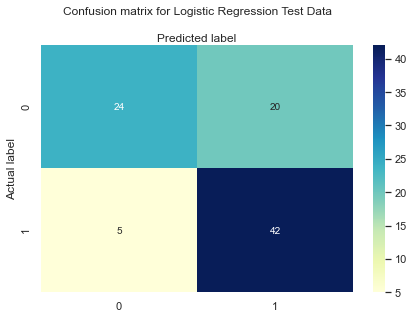

In [81]:
# Visualize Heatmap of Confusion Matrix for test data

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=['Less Chance of HA','High Chance of HA'] # name  of classes
#class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_logreg), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Logistic Regression Test Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [82]:
# Look at the Classification report of test data
from sklearn.metrics import classification_report
print(classification_report(y_test_logreg, y_pred_test_logreg))

              precision    recall  f1-score   support

           0       0.83      0.55      0.66        44
           1       0.68      0.89      0.77        47

    accuracy                           0.73        91
   macro avg       0.75      0.72      0.71        91
weighted avg       0.75      0.73      0.72        91



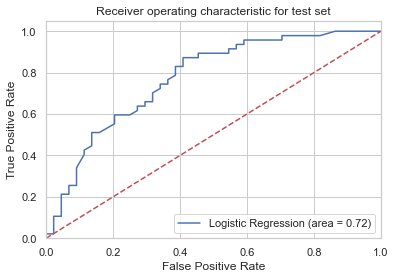

In [83]:
# Visualize the ROC Curve for the test data

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_logreg, logreg.predict(X_test_logreg))
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test_logreg, logreg.predict_proba(X_test_logreg)[:,1])
plt.figure()
plt.plot(fpr_logit, tpr_logit, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for test set')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<b> Performance on training set </b>

In [84]:
# Check for Over/Under fitting
y_pred_train_logreg = logreg.predict(X_train_logreg)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train_logreg, y_train_logreg)))

Accuracy of logistic regression classifier on train set: 0.76


In [85]:
# Look at performance of training data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix_train_logreg = confusion_matrix(y_train_logreg, y_pred_train_logreg)
print(confusion_matrix_train_logreg)
print(classification_report(y_train_logreg, y_pred_train_logreg))

[[ 57  37]
 [ 13 105]]
              precision    recall  f1-score   support

           0       0.81      0.61      0.70        94
           1       0.74      0.89      0.81       118

    accuracy                           0.76       212
   macro avg       0.78      0.75      0.75       212
weighted avg       0.77      0.76      0.76       212



Text(0.5, 257.44, 'Predicted label')

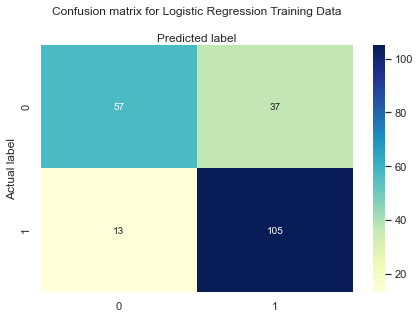

In [86]:
# Visualize Heatmap of Confusion Matrix for training data

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=['Less Chance of HA','High Chance of HA'] # name  of classes
#class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix_train_logreg), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Logistic Regression Training Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [90]:
# Look at the Classification report of training data
from sklearn.metrics import classification_report
print(classification_report(y_train_logreg, y_pred_train_logreg))

              precision    recall  f1-score   support

           0       0.81      0.61      0.70        94
           1       0.74      0.89      0.81       118

    accuracy                           0.76       212
   macro avg       0.78      0.75      0.75       212
weighted avg       0.77      0.76      0.76       212



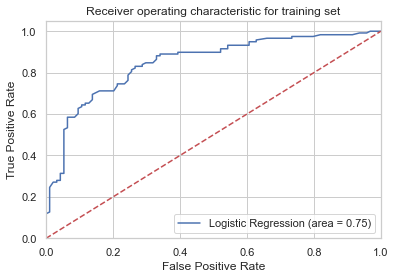

In [87]:
# Visualize the ROC Curve for the training data

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc_train = roc_auc_score(y_train_logreg, logreg.predict(X_train_logreg))
fpr_tr_logit, tpr_tr_logit, thresholds_tr_logit = roc_curve(y_train_logreg, logreg.predict_proba(X_train_logreg)[:,1])
plt.figure()
plt.plot(fpr_tr_logit, tpr_tr_logit, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for training set')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<h3> Tune Hyperparameters for Logistic Regression </h3>

In [92]:
# Grid searching key hyperparametres for logistic regression

# Import required modules
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Dataset used will be the training set: X_train_logreg and y_train_logreg

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=rd)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_logreg, y_train_logreg)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.771342 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.768030 (0.085076) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.768030 (0.085076) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.768030 (0.085076) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.770866 (0.088252) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.770866 (0.088252) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.771342 (0.086969) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.762251 (0.091334) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.762251 (0.091334) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.762706 (0.089768) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.718874 (0.088456) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.718874 (0.088456) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.732229 (0.097917) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.556710 (0.019282) with

<h3> Analyse Misclassified Records </h3>

In [221]:
# Find misclassified records
misclassified_samples = X_test_logreg[y_test_logreg != y_pred_test_logreg]
print(misclassified_samples)

          Age  Sex  MaxHeartRate  ExerciseAngia
204  0.687500    0      0.564885              0
184  0.437500    1      0.435115              0
278  0.604167    0      0.618321              0
208  0.416667    1      0.519084              0
302  0.583333    0      0.786260              0
220  0.708333    0      0.633588              0
228  0.625000    1      0.671756              0
73   0.458333    1      0.877863              1
150  0.770833    1      0.511450              0
197  0.791667    1      0.702290              0
189  0.250000    1      0.664122              0
95   0.500000    1      0.305344              1
138  0.583333    1      0.419847              1
182  0.666667    0      0.748092              0
4    0.583333    0      0.702290              1
283  0.229167    1      0.839695              0
188  0.437500    1      0.702290              0
299  0.333333    1      0.465649              0
110  0.729167    0      0.633588              1
287  0.583333    1      0.709924        

In [187]:
data_logreg['Sex'].value_counts()

1    207
0     96
Name: Sex, dtype: int64

In [188]:
data_logreg['ExerciseAngia'].value_counts()

0    204
1     99
Name: ExerciseAngia, dtype: int64

In [192]:
misclassified_samples.groupby('Sex').mean()

Age  MaxHeartRate  ExerciseAngia
Sex                                       
0    0.641204      0.670908       0.333333
1    0.523284      0.586888       0.235294

In [193]:
misclassified_samples.groupby('ExerciseAngia').mean()

Age       Sex  MaxHeartRate
ExerciseAngia                                  
0              0.576754  0.684211      0.621937
1              0.529762  0.571429      0.599782